In [170]:
from gensim.models import Word2Vec, KeyedVectors
import json
import glob
from collections import defaultdict
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt
import numpy as np

# Create wordembeddings for subcorpora

### Load raw data

In [30]:
def load_data(files):
    data = []
    for f in files:
        with open(f) as inf:
            data.append(json.load(inf))   
    # return sentences in flat format, ignoring text or work boundaries
    return [sentence for works in data for texts in works.values() for sentence in texts]

In [162]:
raw_data = {}
authors = sorted(["marx_engels", "stalin", "trotzki", "kautsky", "lenin", "gramsci", "luxemburg", "thaelmann", "bernstein", "mao"])
for author in authors:
    raw_data[author] = load_data(glob.glob(f"../json/{author}/*"))

### Create and save models

In [163]:
models = {}
for author, sentences in raw_data.items():
    print(f"working on {author}...")
    models[author] = Word2Vec(sentences, size=300, min_count=5, window=100, workers=5).wv  # only storing vectors
print("done.")

working on bernstein...
working on gramsci...
working on kautsky...
working on lenin...
working on luxemburg...
working on mao...
working on marx_engels...
working on stalin...
working on thaelmann...
working on trotzki...
done.


In [49]:
models["marx_engels"].most_similar("partei_n", topn=200)  # check if it worked

[('fraktion_n', 0.7706887125968933),
 ('demokratie_n', 0.7110613584518433),
 ('demokratische_a', 0.7063682079315186),
 ('demokratisch_a', 0.7054676413536072),
 ('minorität_n', 0.6972344517707825),
 ('opposition_n', 0.6824637055397034),
 ('arbeiterpartei_n', 0.6819945573806763),
 ('radikal_a', 0.6628662347793579),
 ('majorität_n', 0.656145453453064),
 ('demokrat_n', 0.6515340805053711),
 ('initiative_n', 0.6317120790481567),
 ('programm_n', 0.6298907995223999),
 ('radikale_n', 0.6298716068267822),
 ('konservativ_a', 0.628358006477356),
 ('proletariat_n', 0.6262416839599609),
 ('republikanische_a', 0.6204836368560791),
 ('revolutionäre_a', 0.6104347109794617),
 ('revolutionär_a', 0.6086121201515198),
 ('ordnungspartei_n', 0.6058914661407471),
 ('kleinbürgerschaft_n', 0.5994099378585815),
 ('mehrheit_n', 0.5991072654724121),
 ('minderheit_n', 0.5954626202583313),
 ('allianz_n', 0.5944140553474426),
 ('liberale_n', 0.5933250188827515),
 ('chartismus_n', 0.5916664600372314),
 ('proletarisch

In [164]:
for author, model in models.items():
    model.save(f"../models/{author}.model")

# Load pre-trained models

In [176]:
models = {}
for author in authors:
    models[author] = KeyedVectors.load(f"../models/{author}.model", mmap="r")

# Create theory embeddings

In [172]:
all_terms = {"Politische Ökonomie": ["wert", "ware", "klasse"],
             "Philosophie": ["dialektik", "widerspruch", "aufhebung"],
             "Staatstheorie": ["staat", "bürokratie", "diktatur"],
             "Sozialismusverständnis": ["sozialismus", "diktatur"],
             "Strategie und Taktik": ["revolution", "bündnis", "reform"]}
all_terms = {cat: [w+"_n" for w in words] for cat, words in all_terms.items()}
term_cats= sorted(all_terms.keys())

In [173]:
class TheoryEmbeddings:
    def __init__(self, models, terms, word_number=200, min_similarity=.5, prio="word_number"):
        # create posibillity to weigh terms
        if type(terms[0]) == tuple:
            self.terms = [t[0] for t in terms]
            self.term_weight = [t[1] for t in terms]
        else:
            self.terms = terms
        
        self.topn = {}
        self.compared_words = defaultdict(set)
        for author, model in models.items():
            this_topn = {}
            for term in self.terms:
                try:
                    this_topn[term] = model.most_similar(term, topn=word_number)
                except KeyError:
                    print(f"WARNING! '{term}' not in vocabulary of {author}!")
                    this_topn[term] = []
                if prio == "min_similarity":
                    this_topn[term] = [w for w in this_topn[term] if w[1] >= min_similarity]
                self.compared_words[term].update(set(t[0] for t in this_topn[term]))
            self.topn[author] = this_topn
        self.compared_words = {term: sorted(list(words)) for term, words in self.compared_words.items()}
        
        self.vectors = defaultdict(lambda: defaultdict(list))
        for author, model in models.items():
            for term in terms:
                for contextword in self.compared_words[term]:
                    try:
                        v = model.similarity(term, contextword)
                    except KeyError:
                        v = 0.0
                    self.vectors[author][term].append(v)
                        
        

In [174]:
def theory_similarity(a1, a2, element):
    terms = all_terms[element]
    te = TheoryEmbeddings({a1: models[a1], a2: models[a2]}, terms)
    sims = []
    for term in terms:
        sim = 1- cosine(te.vectors[a1][term], te.vectors[a2][term])
        sims.append(sim)
    return sum(sims)/ len(sims)
    
    

# Visualize results in Heatmap

### For one Theorieelement

In [142]:
authors = ["marx_engels", "stalin", "trotzki", "kautsky"]
elem = "Staatstheorie"
all_sims = []
for a1 in authors:
    values = []
    for a2 in authors:
        values.append(theory_similarity(a1, a2, elem))
    all_sims.append(values)

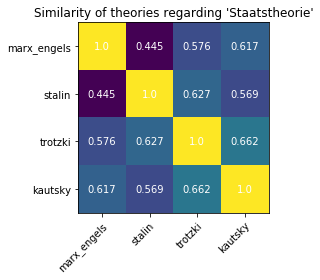

In [145]:
fig, ax = plt.subplots()
    
im = ax.imshow(all_sims)

# We want to show all ticks...
ax.set_xticks(np.arange(len(authors)))
ax.set_yticks(np.arange(len(authors)))
# ... and label them with the respective list entries
ax.set_xticklabels(authors)
ax.set_yticklabels(authors)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(authors)):
    for j in range(len(authors)):
        text = ax.text(j, i, round(all_sims[i][j],3),
                       ha="center", va="center", color="w")

ax.set_title(f"Similarity of theories regarding '{elem}'")
fig.tight_layout()
plt.show()

### For all Theorieelemente

WARNING! 'ware_n' not in vocabulary of thaelmann!


/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:702: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


WARNING! 'ware_n' not in vocabulary of gramsci!
WARNING! 'ware_n' not in vocabulary of thaelmann!
WARNING! 'ware_n' not in vocabulary of gramsci!
WARNING! 'ware_n' not in vocabulary of thaelmann!
WARNING! 'ware_n' not in vocabulary of gramsci!
WARNING! 'ware_n' not in vocabulary of thaelmann!
WARNING! 'ware_n' not in vocabulary of gramsci!
WARNING! 'ware_n' not in vocabulary of thaelmann!
WARNING! 'ware_n' not in vocabulary of gramsci!
WARNING! 'ware_n' not in vocabulary of thaelmann!
WARNING! 'ware_n' not in vocabulary of thaelmann!
WARNING! 'ware_n' not in vocabulary of thaelmann!
WARNING! 'ware_n' not in vocabulary of thaelmann!
WARNING! 'ware_n' not in vocabulary of thaelmann!
WARNING! 'ware_n' not in vocabulary of thaelmann!
WARNING! 'ware_n' not in vocabulary of thaelmann!
WARNING! 'ware_n' not in vocabulary of thaelmann!
WARNING! 'ware_n' not in vocabulary of gramsci!


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:392: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


WARNING! 'ware_n' not in vocabulary of thaelmann!
WARNING! 'ware_n' not in vocabulary of gramsci!
WARNING! 'ware_n' not in vocabulary of thaelmann!
WARNING! 'ware_n' not in vocabulary of gramsci!
WARNING! 'ware_n' not in vocabulary of gramsci!
WARNING! 'ware_n' not in vocabulary of gramsci!
WARNING! 'ware_n' not in vocabulary of gramsci!
WARNING! 'ware_n' not in vocabulary of gramsci!
WARNING! 'ware_n' not in vocabulary of gramsci!
WARNING! 'ware_n' not in vocabulary of gramsci!
WARNING! 'ware_n' not in vocabulary of thaelmann!
WARNING! 'ware_n' not in vocabulary of gramsci!
WARNING! 'ware_n' not in vocabulary of gramsci!
WARNING! 'dialektik_n' not in vocabulary of thaelmann!
WARNING! 'widerspruch_n' not in vocabulary of thaelmann!
WARNING! 'dialektik_n' not in vocabulary of gramsci!
WARNING! 'aufhebung_n' not in vocabulary of gramsci!
WARNING! 'dialektik_n' not in vocabulary of thaelmann!
WARNING! 'widerspruch_n' not in vocabulary of thaelmann!
WARNING! 'dialektik_n' not in vocabulary

WARNING! 'reform_n' not in vocabulary of gramsci!
WARNING! 'reform_n' not in vocabulary of thaelmann!
WARNING! 'bündnis_n' not in vocabulary of bernstein!
WARNING! 'reform_n' not in vocabulary of gramsci!
WARNING! 'reform_n' not in vocabulary of thaelmann!
WARNING! 'reform_n' not in vocabulary of thaelmann!
WARNING! 'reform_n' not in vocabulary of thaelmann!
WARNING! 'reform_n' not in vocabulary of thaelmann!
WARNING! 'reform_n' not in vocabulary of thaelmann!
WARNING! 'reform_n' not in vocabulary of thaelmann!
WARNING! 'reform_n' not in vocabulary of thaelmann!
WARNING! 'bündnis_n' not in vocabulary of bernstein!
WARNING! 'reform_n' not in vocabulary of thaelmann!
WARNING! 'reform_n' not in vocabulary of gramsci!
WARNING! 'reform_n' not in vocabulary of thaelmann!
WARNING! 'bündnis_n' not in vocabulary of bernstein!
WARNING! 'reform_n' not in vocabulary of gramsci!
WARNING! 'bündnis_n' not in vocabulary of bernstein!
WARNING! 'bündnis_n' not in vocabulary of bernstein!
WARNING! 'bündn

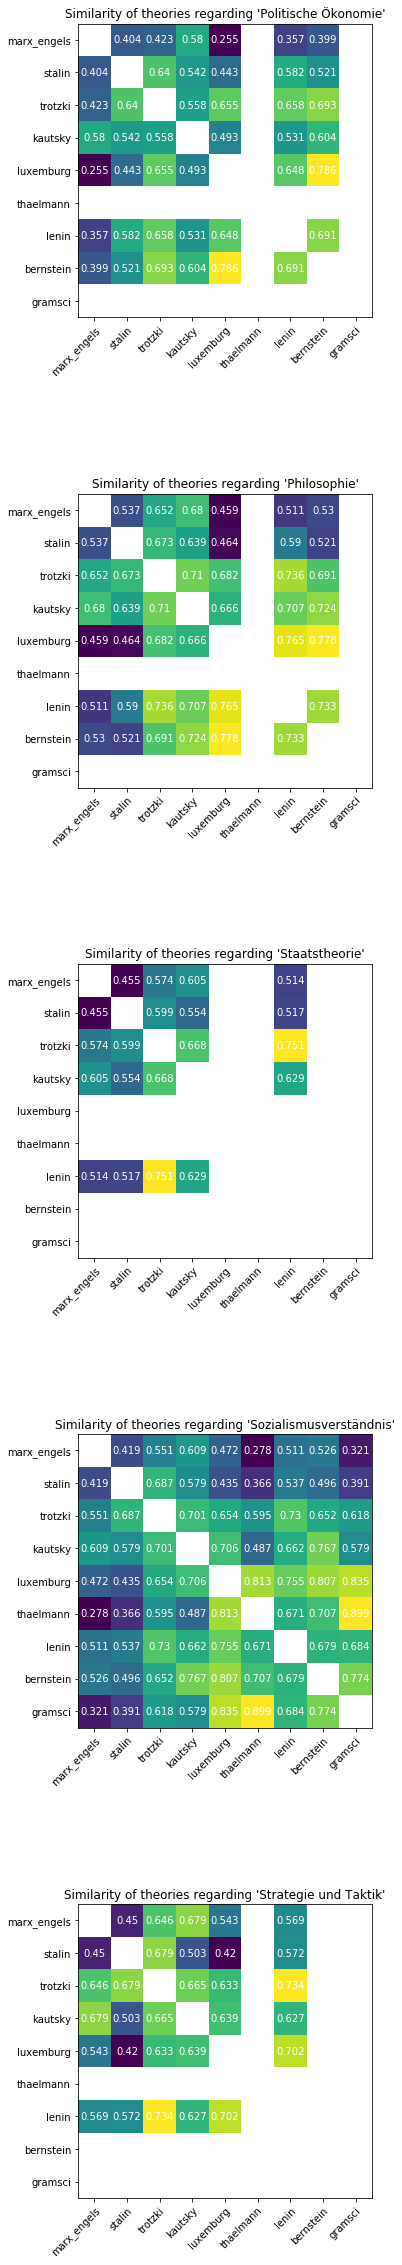

In [177]:
authors = ["marx_engels", "stalin", "trotzki", "kautsky", "luxemburg", "thaelmann", "lenin", "bernstein", "gramsci"]


fig, axes = plt.subplots(len(all_terms), figsize=(10, 40))

for ax, elem in zip(axes, all_terms.keys()):
    all_sims = []
    for a1 in authors:
        values = []
        for a2 in authors:
            if a1 == a2:
                values.append(np.nan)
            else:
                values.append(theory_similarity(a1, a2, elem))
        all_sims.append(values)
       
    ax.imshow(all_sims)
    
    # We want to show all ticks...
    ax.set_xticks(np.arange(len(authors)))
    ax.set_yticks(np.arange(len(authors)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(authors)
    ax.set_yticklabels(authors)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(authors)):
        for j in range(len(authors)):
            ax.text(j, i, round(all_sims[i][j],3),
                           ha="center", va="center", color="w")

    ax.set_title(f"Similarity of theories regarding '{elem}'")
    
#fig.tight_layout()
plt.subplots_adjust(hspace=.6)
plt.savefig("figures/similarity_heatmap.pdf")